In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
trees = pd.read_csv('../data/reforestree/field_data.csv')
trees = trees[["site", "X", "Y", "lon", "lat", "carbon"]]
trees.head()

,site,X,Y,lon,lat,carbon
0,Nestor Macias RGB,2761.628615,6831.070678,-79.576630,-2.181226,2.123249
1,Nestor Macias RGB,5067.141765,7729.961820,-79.576412,-2.181312,2.123249
2,Nestor Macias RGB,6025.223497,9026.909643,-79.576322,-2.181438,2.123249
3,Nestor Macias RGB,7803.490078,10637.681956,-79.576154,-2.181593,2.123249
4,Nestor Macias RGB,7531.400369,9648.963864,-79.576179,-2.181498,2.123249


In [27]:
# gps_error: {site: [lon_error, lat_error]}
gps_error = {"Flora Pluas RGB": [0.25, 0.66],
            "Nestor Macias RGB": [0.6, 0.53],
            "Manuel Macias RGB": [0.69, 0.30],
            "Leonor Aspiazu RGB": [0.47, 0.45],
            "Carlos Vera Arteaga RGB": [0.26, 0.59],
            "Carlos Vera Guevara RGB": [0.27, 0.65]}

[1.05830303e+07 8.42164649e+08]


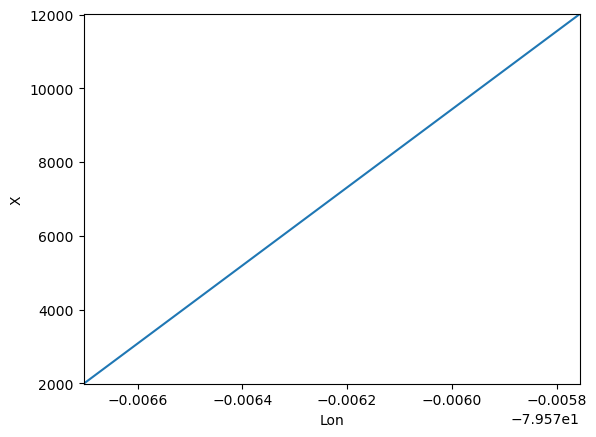

In [26]:
site = "Nestor Macias RGB"
trees_plot = trees[trees.site == site].sort_values(by="lon")
coeff = np.polyfit(trees_plot.lon, trees_plot.X, 1)
print(coeff)
plt.plot(trees_plot.lon, trees_plot.X)
x = np.linspace(min(trees_plot.lon), max(trees_plot.lon))
# plt.plot(x, x * coeff[0] + coeff[1], 'k', '--', alpha=0.5)
plt.xlabel("Lon")
plt.ylabel("X")
plt.axis([min(trees_plot.lon), max(trees_plot.lon), min(trees_plot.X), max(trees_plot.X)])
plt.show()

In [30]:
xy_error = {}
for site in gps_error.keys():
    trees_site = trees[trees.site == site].sort_values(by="lon")
    coeff_x = np.polyfit(trees_site.lon, trees_site.X, 1)
    trees_site = trees_site.sort_values(by="lat")
    coeff_y = np.polyfit(trees_site.lat, trees_site.Y, 1)
    xy_error[site] = [abs(coeff_x[0] * gps_error[site][0]), abs(coeff_y[0] * gps_error[site][1])]

In [31]:
xy_error

{'Flora Pluas RGB': [3086797.6261693547, 7621712.5618777955],
 'Nestor Macias RGB': [6349818.177051305, 5491151.513695437],
 'Manuel Macias RGB': [6897992.047832904, 3174760.441145765],
 'Leonor Aspiazu RGB': [5095953.974123914, 4758117.918822851],
 'Carlos Vera Arteaga RGB': [2799276.086896204, 6572901.906396625],
 'Carlos Vera Guevara RGB': [2747342.927273798, 6055735.8434736775]}

In [134]:
patch_size = 2000
patches_array = []
for site in gps_error.keys():
    for x in range(3):
        for y in range(3):
            coordinates = np.array([(x,y), (x+1,y), (x+1,y+1), (x,y+1)]) * patch_size
            patches_array.append([site, coordinates[0], coordinates[1], coordinates[2], coordinates[3]])
patches = pd.DataFrame(patches_array, columns=["site", "a", "b", "c", "d"])
patches.head()

,site,a,b,c,d
0,Flora Pluas RGB,"[0, 0]","[2000, 0]","[2000, 2000]","[0, 2000]"
1,Flora Pluas RGB,"[0, 2000]","[2000, 2000]","[2000, 4000]","[0, 4000]"
2,Flora Pluas RGB,"[0, 4000]","[2000, 4000]","[2000, 6000]","[0, 6000]"
3,Flora Pluas RGB,"[2000, 0]","[4000, 0]","[4000, 2000]","[2000, 2000]"
4,Flora Pluas RGB,"[2000, 2000]","[4000, 2000]","[4000, 4000]","[2000, 4000]"


In [36]:
carbon_distributions = {}

padding = 500

for site in gps_error.keys():

    max_x = int(np.max(trees.X) + padding)
    max_y = int(np.max(trees.Y) + padding)

    carbon_distribution = np.zeros((max_y, max_x))

    trees_site = trees[trees.site == site]
    for x, y, carbon in zip(trees_site.X, trees_site.Y, trees_site.carbon):
        carbon_distribution[int(y), int(x)] = carbon

    carbon_distributions[site] = carbon_distribution

In [67]:
'''
def in_rectangle(point, vertices):
    
    dot_products = [np.dot(point - vertices[0], vertices[1]-vertices[0]), np.dot(point - vertices[0], vertices[3]-vertices[0])]
    if np.any(dot_products < 0):
        return False
    if np.linalg.norm((point - vertices[0])) > np.linalg.norm((point - vertices[0]))
    
    p = point - vertices[0]
    x = vertices[1]-vertices[0]
    y = vertices[3]-vertices[0]
    p_x = (np.dot(p, x)/np.dot(x, x))*x
    p_y = (np.dot(p, y)/np.dot(y, y))*y

    print(p_x, p_y)
    print(np.linalg.norm(x - p_x))

    if np.linalg.norm(x - p_x) < 0 & np.linalg.norm(x - p_x) < 0:
        return False
    if 

vertices = np.array([[0, 0], [2000, 0], [2000, 2000], [0, 2000]])
point = np.array((1000, 2500))
in_rectangle(point, vertices)
'''

[1000.    0.] [   0. 2500.]


In [135]:
def in_rectangle(point, vertices):
    if point[0] >= vertices[0][0] and point[0] <= vertices[1][0] and point[1] >= vertices[0][1] and point[1] <= vertices[3][1]:
        return True
    return False

carbon_patches = []
tree_patch = {}
for idx_patch, patch in patches.iterrows():
    carbon_patch = 0
    vertices = np.array([patch.a, patch.b, patch.c, patch.d])

    for idx_tree, tree in trees[trees.site == patch.site].iterrows():
        point = np.array((tree.X, tree.Y))
        if in_rectangle(point, vertices):
            carbon_patch += tree.carbon
            tree_patch[idx_tree] = idx_patch
    carbon_patches.append(carbon_patch)

patches['carbon'] = carbon_patches
trees.loc[list(tree_patch.keys()), 'patch'] = list(tree_patch.values())
trees.patch = [str(x) for x in trees.patch]

In [132]:
import cv2
import seaborn as sns

site = "Flora Pluas RGB"
patches_site = patches[patches.site == site]

path = '../data/reforestree/wwf_ecuador/RGB Orthomosaics/{}.tif'.format(site)
img = cv2.imread(path)
img = np.array(img)
print(img.shape)

(15578, 16782, 3)


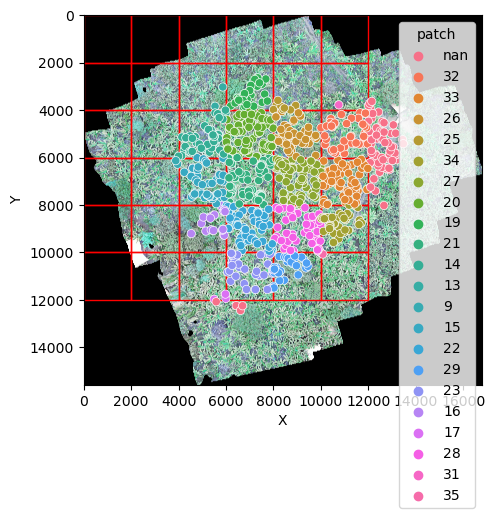

In [133]:
ax = plt.gca()
plt.imshow(img)

for idx_patch, patch in patches_site.iterrows():
    vertices = np.array([patch.a, patch.b, patch.c, patch.d])
    patch_rec = plt.Rectangle(vertices[0], np.linalg.norm(vertices[1] - vertices[0]), np.linalg.norm(vertices[3] - vertices[0]), linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(patch_rec)
    
sns.scatterplot(data=trees[trees.site == site], x="X", y="Y", hue="patch")

plt.show()